# Imports

In [1]:
import collections
import os
import re
from collections import defaultdict

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from folium import FeatureGroup, LayerControl
#!pip install rapidfuzz
from rapidfuzz import process, fuzz
from scipy.stats import trim_mean

# Methodology

## Technical Implementation & Analysis

The research was conducted in Python using `pandas` and `numpy` for data manipulation, `rapidfuzz` for string matching, and `folium`/`seaborn` for visualization.\
The analytical workflow was close to the Data Science Process:
- We defined our research questions.
- Explored possible data sources and found the dataset.
- Explored, cleaned and enriched the data.
- Ran evaluations and visualization.
- Derived new knowledge from the evaluations and visualization.

## Origin of the data

The primary data was gathered by Francesco Bruno, Mohammad Maghrour Zefreh, Oskar Fröidh of the KTH-Stockholm. The purpose was to "stress test" Short-Haul Flight (SHF) bans, specifically to estimate the trade-offs between environmental savings and increased travel times, and to assess whether existing rail capacity in Sweden and Norway could absorb shifted air passenger traffic(BRUNO 2025). During our data discovery phase, we found this dataset and immediately declared it our main data source, as it contained all the information we needed to answer our research questions.

### Sources

The data focuses primarily on air and rail transport within Europe in 2023. Geographically, it covers the 25 EU member states (excluding Cyprus and Malta), as well as Norway, Serbia, Switzerland and the United Kingdom. Link to the dataset: https://data.4tu.nl/datasets/f045231a-a153-43cb-a5b2-9b37f4528ccf/1 \
\
Specific data sources include:
- Air Traffic Data: Schedules for commercial flights between November 2023 and November 2024 were sourced from the OAG Schedules database, providing details on flight numbers, carriers, scheduled times, aircraft types, and seat capacity.
- Passenger Flows: 2023 passenger demand data, segmented by journey type (point-to-point, behind, beyond, and bridge), was retrieved from the OAG Traffic Analyser.
- Rail Travel Times: Commercial rail schedules and transfer times were obtained from Rome2Rio , while technical running times based on infrastructure capabilities were sourced from Signal.eu.org.
- Rail Infrastructure & Capacity: Detailed data on rail infrastructure (stations, line sections) and capacity utilization for the Swedish and Norwegian networks was provided by the Swedish Transport Administration (Trafikverket) and the Norwegian Railway Directorate (Jernbanedirektoratet).
- Geospatial Data: Rail station locations were identified using the GeoPy library with Nominatim, and travel times between urban areas and airports were calculated using the Google Distance Matrix API.
- Routing: The Open Source Routing Machine (OSRM), based on Open Street Map data, was used to compute fastest rail routes.

### Data Structure

The dataset contains five interconnected datasets provided in Excel (.xlsx) format:
- **Airports_Indicators.xlsx**: Contains performance metrics for 58 airports, including total passenger movements (Potential, Connecting, and Total), service levels, and area analysis (Latitude/Longitude coordinates).
- **Airports_Rail_Access.xlsx**: Details rail accessibility for 318 locations, mapping airports to specific rail stations. It includes data on passenger segments (Point-to-Point, Hub, Spoke), station infrastructure (High-Speed Rail presence, Metro/Tram connections), and rail line characteristics.
- **Alternative_Rail_Routes_Bidirectional.xlsx & Unidirectional.xlsx**: Provides comparative route data for substituting flights with rail, including distance, duration, and frequency metrics for both directions of travel.
- **Candidate_Rail_Routes.xlsx**: Lists potential rail corridors identified for air-to-rail substitution analysis.

# 1. Load Data

In [2]:
# Path to the data directory
data_path = "../Data"

# List all xlsx files in the data directory
xlsx_files = [f for f in os.listdir(data_path) if f.endswith(".xlsx")]

xlsx_files

['Airports_Indicators.xlsx',
 'Airports_Rail_Access.xlsx',
 'Alternative_Rail_Routes_Bidirectional.xlsx',
 'Alternative_Rail_Routes_Unidirectional.xlsx',
 'Candidate_Rail_Routes.xlsx']

# 2. Descriptive Analysis of main datasets
(Author: Philipp Schott)

This section provides a general descriptive overview of the datasets used across all research questions, in order to avoid repetition.

## 2.1 Basic Descriptive Statistics

In [3]:
# Dictionary to hold dataframes
dataframes = {}

for file in xlsx_files:
    file_path = os.path.join(data_path, file)
    if file == "Airports_Rail_Access.xlsx":
        df = pd.read_excel(file_path, header=1, sheet_name=0)  # multi-index columns
    else:
        df = pd.read_excel(file_path, sheet_name=0)  # only 1 sheet per file
    dataframes[file] = df
    print(f"Loaded: {file} — Shape: {df.shape} - Missing values: {df.isnull().sum().sum()}")

Loaded: Airports_Indicators.xlsx — Shape: (58, 10) - Missing values: 0
Loaded: Airports_Rail_Access.xlsx — Shape: (318, 25) - Missing values: 309
Loaded: Alternative_Rail_Routes_Bidirectional.xlsx — Shape: (3814, 16) - Missing values: 5148
Loaded: Alternative_Rail_Routes_Unidirectional.xlsx — Shape: (7425, 30) - Missing values: 27010
Loaded: Candidate_Rail_Routes.xlsx — Shape: (8612, 11) - Missing values: 3172


### 2.1.1 Helper Function to Describe a Dataset

In [4]:
# Helper function to describe a dataset
def describe_dataset(df, name="Dataset"):
    print(f"\n===== {name} =====\n")

    print("Shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)

    print("\nMissing values:")
    print(df.isna().sum())

    print("\nDuplicated rows:", df.duplicated().sum())

    print("\nStatistical summary (numeric):")
    display(df.describe())

    numeric_df = df.select_dtypes(include=np.number)
    if numeric_df.shape[1] > 1:
        plt.figure(figsize=(6, 4))
        sns.heatmap(numeric_df.corr(), cmap="Blues")
        plt.title("Correlation Heatmap")
        plt.show()

## 2.2 Airports_Indicators.xlsx


===== Airports_Indicators.xlsx =====

Shape: (58, 10)

Data types:
Airport                   object
IATA Code                 object
Latitude                 float64
Longitude                float64
Potential Passengers       int64
Total Passengers           int64
Connecting Passengers      int64
Service ARISP            float64
Theoretical ARISP        float64
Delta ARISP              float64
dtype: object

Missing values:
Airport                  0
IATA Code                0
Latitude                 0
Longitude                0
Potential Passengers     0
Total Passengers         0
Connecting Passengers    0
Service ARISP            0
Theoretical ARISP        0
Delta ARISP              0
dtype: int64

Duplicated rows: 0

Statistical summary (numeric):


,Latitude,Longitude,Potential Passengers,Total Passengers,Connecting Passengers,Service ARISP,Theoretical ARISP,Delta ARISP
count,58.000000,58.000000,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01,5.800000e+01
mean,49.224818,10.284658,2.012450e+06,1.515504e+07,4.326045e+06,5.009061e+05,8.030926e+05,3.021865e+05
std,5.962397,8.213758,3.470306e+06,1.602023e+07,5.821703e+06,1.010985e+06,1.587815e+06,5.926990e+05
min,36.678545,-6.064050,9.600000e+01,1.460470e+05,9.671000e+03,0.000000e+00,0.000000e+00,-3.389497e+04
25%,45.795296,4.827758,2.429600e+04,1.151565e+06,4.204478e+05,4.772020e+03,7.762903e+03,3.104301e+03
50%,50.277127,10.459842,3.668635e+05,9.911437e+06,1.928610e+06,7.455793e+04,1.302197e+05,5.780261e+04
75%,52.432262,15.346914,2.745792e+06,2.370087e+07,5.580579e+06,4.360713e+05,7.534728e+05,3.425787e+05
max,63.454766,26.102554,1.578106e+07,6.582116e+07,2.449154e+07,4.844676e+06,7.420966e+06,2.576290e+06


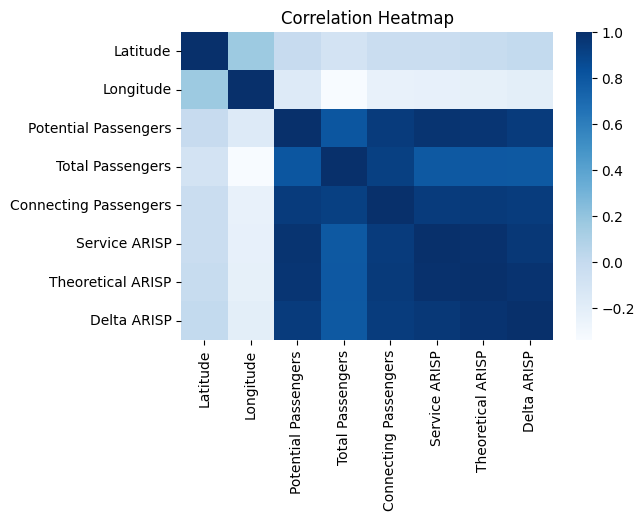

In [5]:
Airports_Indicators = dataframes["Airports_Indicators.xlsx"]
describe_dataset(Airports_Indicators, name="Airports_Indicators.xlsx")

## 2.3 Airports_Rail_Access.xlsx


===== Airports_Rail_Access.xlsx =====

Shape: (318, 25)

Data types:
Airport                              object
IATA Code                            object
Ptp Passengers                        int64
Spoke Passengers                      int64
Hub Passengers                        int64
Ptp Passengers [%]                  float64
Spoke Passengers [%]                float64
Hub Passengers [%]                  float64
Total Passengers                      int64
Generated Passengers                  int64
Station name                         object
Station address (Signal.eu)          object
Station Coordinates                  object
UIC Code                             object
Through Line                         object
Detour Line                          object
Branch Line                          object
Linked to Line                       object
High-Speed Rail                      object
Long-distance                        object
Regional/suburban                    object
City-A

,Ptp Passengers,Spoke Passengers,Hub Passengers,Ptp Passengers [%],Spoke Passengers [%],Hub Passengers [%],Total Passengers,Generated Passengers,Metro/Tram/ People Mover
count,3.180000e+02,3.180000e+02,3.180000e+02,318.000000,318.000000,318.000000,3.180000e+02,3.180000e+02,318.000000
mean,3.508013e+06,7.167471e+05,4.062325e+05,0.803486,0.177438,0.019076,4.630993e+06,4.224760e+06,0.116352
std,6.722529e+06,1.472785e+06,1.700698e+06,0.152214,0.147540,0.046518,9.376213e+06,8.075694e+06,0.321152
min,7.400000e+01,0.000000e+00,0.000000e+00,0.212342,0.000000,0.000000,7.400000e+01,7.400000e+01,0.000000
25%,1.043310e+05,1.475275e+04,3.000000e+00,0.715459,0.072356,0.000018,1.445625e+05,1.445625e+05,0.000000
50%,5.147080e+05,1.175675e+05,1.475500e+03,0.831807,0.145861,0.002694,6.865005e+05,6.850645e+05,0.000000
75%,3.008057e+06,6.749088e+05,6.107100e+04,0.918196,0.228543,0.013741,3.939062e+06,3.913768e+06,0.000000
max,4.132963e+07,1.319577e+07,1.596449e+07,1.000000,0.787658,0.367471,6.582116e+07,5.452539e+07,1.000000


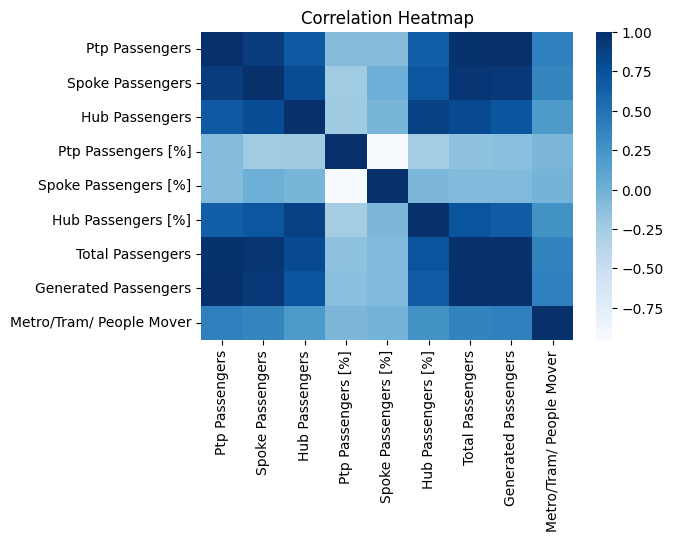

In [6]:
Airports_Rail_Access = dataframes["Airports_Rail_Access.xlsx"]
describe_dataset(Airports_Rail_Access, name="Airports_Rail_Access.xlsx")

## 2.4 Alternative_Rail_Routes_Bidirectional.xlsx


===== Alternative_Rail_Routes_Bidirectional.xlsx =====

Shape: (3814, 16)

Data types:
Bidirectional Route Name         object
Origin                           object
Destination                      object
Origin Coordinates               object
Destination Coordinates          object
Rail Theoretical Travel Time    float64
Rail Service Travel Time        float64
Air Travel Time                 float64
Valued Air Travel Time          float64
Passenger Flows                   int64
Theoretical ARISP               float64
Service ARISP                   float64
Theoretical Time Difference     float64
Service Time Difference         float64
Theoretical Time Increase       float64
Service Time Increase           float64
dtype: object

Missing values:
Bidirectional Route Name           0
Origin                             0
Destination                        0
Origin Coordinates                 0
Destination Coordinates            0
Rail Theoretical Travel Time     145
Rail Service Travel

,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Passenger Flows,Theoretical ARISP,Service ARISP,Theoretical Time Difference,Service Time Difference,Theoretical Time Increase,Service Time Increase
count,3669.000000,2672.000000,3814.000000,3814.000000,3814.000000,3669.000000,2672.000000,3669.000000,2672.000000,3669.000000,2672.000000
mean,813.115696,960.416783,126.690067,205.237908,29901.614840,12396.519915,10654.901796,-608.744220,-775.348004,279.280156,396.953143
std,545.448511,541.960755,45.428213,73.593705,64479.668828,34712.397546,28774.821147,494.115529,494.956231,198.164879,190.191318
min,55.000000,72.239981,32.310987,52.343799,1.000000,0.115000,0.105257,-2705.971280,-3066.346429,-35.552733,-2.777940
25%,399.262363,539.802579,91.602388,148.395868,1489.250000,409.891714,304.175628,-837.030255,-1035.902527,145.700045,265.104028
50%,668.503265,859.030815,121.099374,196.180986,5316.000000,1544.166346,1267.198736,-461.439997,-675.040919,225.004692,366.562296
75%,1081.685358,1264.176233,156.459593,253.464541,21474.000000,6568.368366,6325.624665,-240.942738,-392.541216,351.926674,499.324552
max,3067.860082,3424.000000,307.085610,497.478689,768916.000000,484799.778635,541544.345771,35.305996,2.064124,2641.564374,1638.578444


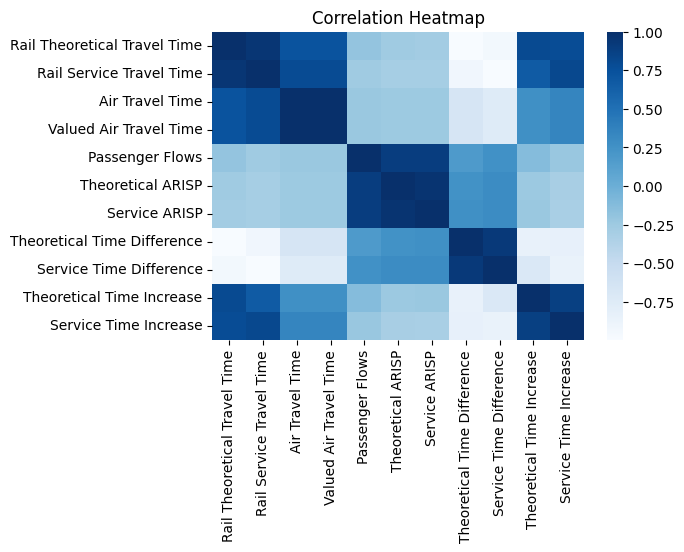

In [7]:
Alternative_Rail_Routes_Bidirectional = dataframes["Alternative_Rail_Routes_Bidirectional.xlsx"]
describe_dataset(Alternative_Rail_Routes_Bidirectional, name="Alternative_Rail_Routes_Bidirectional.xlsx")

## 2.5 Alternative_Rail_Routes_Unidirectional.xlsx

In [8]:
Alternative_Rail_Routes_Unidirectional = dataframes["Alternative_Rail_Routes_Unidirectional.xlsx"]
describe_dataset(df, name="Alternative_Rail_Routes_Unidirectional.xlsx")


===== Alternative_Rail_Routes_Unidirectional.xlsx =====

Shape: (8612, 11)

Data types:
Airport OD                       object
Origin                           object
Destination                      object
Origin Coordinates               object
Destination Coordinates          object
Route                            object
Distance and Theoretical Time    object
Theoretical Travel Time          object
Distance                         object
Service Travel Time              object
Mode                             object
dtype: object

Missing values:
Airport OD                         0
Origin                             0
Destination                        0
Origin Coordinates                 6
Destination Coordinates            6
Route                            790
Distance and Theoretical Time    790
Theoretical Travel Time          790
Distance                         790
Service Travel Time                0
Mode                               0
dtype: int64

Duplicated rows: 0


,Airport OD,Origin,Destination,Origin Coordinates,Destination Coordinates,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode
count,8612,8612,8612,8606,8606,7822,7822,7822,7822,8612,8612
unique,5720,330,330,325,325,1128,7477,1349,6485,1796,2
top,CPH-LHR,London Stansted Airport,London Stansted Airport,"51.889260,0.262154","51.889260,0.262154","Ligne de Combs-la-Ville à Saint-Louis (LGV), L...",-,1900-01-01 01:00:00,-,-,Train
freq,3,179,179,179,179,200,12,108,12,3161,5451


## 2.6 Candidate_Rail_Routes.xlsx

In [9]:
Candidate_Rail_Routes = dataframes["Candidate_Rail_Routes.xlsx"]
describe_dataset(Candidate_Rail_Routes, name="Candidate_Rail_Routes.xlsx")


===== Candidate_Rail_Routes.xlsx =====

Shape: (8612, 11)

Data types:
Airport OD                       object
Origin                           object
Destination                      object
Origin Coordinates               object
Destination Coordinates          object
Route                            object
Distance and Theoretical Time    object
Theoretical Travel Time          object
Distance                         object
Service Travel Time              object
Mode                             object
dtype: object

Missing values:
Airport OD                         0
Origin                             0
Destination                        0
Origin Coordinates                 6
Destination Coordinates            6
Route                            790
Distance and Theoretical Time    790
Theoretical Travel Time          790
Distance                         790
Service Travel Time                0
Mode                               0
dtype: int64

Duplicated rows: 0

Statistical summ

,Airport OD,Origin,Destination,Origin Coordinates,Destination Coordinates,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode
count,8612,8612,8612,8606,8606,7822,7822,7822,7822,8612,8612
unique,5720,330,330,325,325,1128,7477,1349,6485,1796,2
top,CPH-LHR,London Stansted Airport,London Stansted Airport,"51.889260,0.262154","51.889260,0.262154","Ligne de Combs-la-Ville à Saint-Louis (LGV), L...",-,1900-01-01 01:00:00,-,-,Train
freq,3,179,179,179,179,200,12,108,12,3161,5451


# Q1: How can we estimate the typical travel time between the city’s central rail station and its nearest major airport, and how should this time be incorporated into the total air travel duration?
 
(Author: Philipp Schott)

## Data overview

### Analyse Airports_Rail_Access.xlsx

In [10]:
# Important columns
df_ARA_clean = Airports_Rail_Access[["Airport", "IATA Code", "Train connection to City Station"]].copy()

# Rename columns for easier access
df_ARA_clean = df_ARA_clean.rename(columns={
    "Airport": "airport",
    "IATA Code": "iata_code",
    "Train connection to City Station": "connection_text"
})

# Extract city airport time in minutes using regex
df_ARA_clean["city_airport_time_min"] = df_ARA_clean["connection_text"].str.extract(r"(\d+)\s*min").astype("Int64")
df_ARA_clean.drop(columns=["connection_text"], inplace=True)

### Analyse Alternative_Rail_Routes_Bidirectional.xlsx

In [11]:
# Important columns
df_ARRB_clean = Alternative_Rail_Routes_Bidirectional[["Origin", "Destination", "Air Travel Time"]].copy()

# Rename columns for easier access
df_ARRB_clean = df_ARRB_clean.rename(columns={
    "Origin": "origin",
    "Destination": "destination",
    "Air Travel Time": "air_travel_time_min"
})

# Convert air travel time to numeric (in minutes)
df_ARRB_clean["air_travel_time_min"] = df_ARRB_clean["air_travel_time_min"].round().astype(int)

After this one could see that the origin and destination are not allways given as IATA codes but by airport names.

In [12]:
# Origin: all not IATA
ARRB_origin_no_iata = df_ARRB_clean.loc[df_ARRB_clean["origin"].str.match(r"^[A-Z]{3}$") == False, "origin"].unique()

# Destination: all not IATA
ARRB_destination_no_iata = df_ARRB_clean.loc[
    df_ARRB_clean["destination"].str.match(r"^[A-Z]{3}$") == False, "destination"].unique()

# Combine both lists and get unique values
all_non_iata = sorted(set(ARRB_origin_no_iata) | set(ARRB_destination_no_iata))

print(f"Total unique non-IATA entries in Origin and Destination: {len(all_non_iata)}")

Total unique non-IATA entries in Origin and Destination: 257


## Map Airport Names to IATA Codes

### Mapping by "Airports_Rail_Access.xlsx"

An initial attempt was made to map airport names to IATA codes using the `Airports_Rail_Access.xlsx` dataset. While this approach allowed for a limited number of matches, only 638 origin-destination pairs could be successfully resolved, leaving a large proportion of connections unmatched. Given this low coverage relative to the size of the dataset, the approach was deemed insufficient for a reliable estimation of typical
travel times and was therefore discarded. 

Consequently, a more comprehensive external airport IATA mapping was used in the subsequent analysis.

### Mapping by "airports.csv"

Instead I extended the mapping by using the "airports.csv" file from https://ourairports.com/data/, which contains more airport names and IATA codes. After this I tried to map the names in origin and destination to IATA codes based on to probability of which airport name they match the most by fuzzy matching. Because some names did not match exactly with the names in the "airports.csv".

In [13]:
# Load global airports data
df_airports_global_raw = pd.read_csv("../Data/airports.csv")

# Filter relevant columns and drop rows with missing IATA codes
df_airports_global = df_airports_global_raw[
    ~df_airports_global_raw["iata_code"].isna()
][["name", "municipality", "iata_code"]]

# Get unique airport names and cities from global dataset
global_airport_names = df_airports_global["name"].str.strip().unique()
global_airport_cities = df_airports_global["municipality"].str.strip().unique()

# Exact matches in Airport Names und Cities
exact_name_matches = set(all_non_iata) & set(global_airport_names)
exact_city_matches = set(all_non_iata) & set(global_airport_cities)

print("exakte Airport-Name-Matches:", len(exact_name_matches))
print("exakte City-Matches:", len(exact_city_matches))

exakte Airport-Name-Matches: 0
exakte City-Matches: 160


In [14]:
# Create lookup dictionaries
city_dict = dict(zip(df_airports_global["municipality"], df_airports_global["iata_code"]))
name_dict = dict(zip(df_airports_global["name"], df_airports_global["iata_code"]))
airport_names = df_airports_global["name"].tolist()


# Fuzzy lookup function
def fuzzy_lookup(name):
    match = process.extractOne(
        name,
        airport_names,
        scorer=fuzz.WRatio,
        score_cutoff=85  # for high confidence matches
    )
    if match:
        best_name = match[0]
        return name_dict.get(best_name)
    return None

In [15]:
# Enhanced get_iata function with fuzzy lookup
def get_iata(value):
    if pd.isna(value):
        return "unknown"

    v = str(value).strip()

    # Case 1. Is it already an IATA code?
    if re.fullmatch(r"[A-Z]{3}", v):
        return v

    # Case 2. City match
    if v in city_dict:
        return city_dict[v]

    # Case 3. Full airport name match
    if v in name_dict:
        return name_dict[v]

    # Case 4. Fuzzy match (if above fails)
    fuzzy = fuzzy_lookup(v)
    if fuzzy:
        return fuzzy

    # Case 5. No match found
    return "unknown"

In [16]:
# Generate new columns with IATA codes using enhanced function
df_ARRB_clean["origin_iata"] = df_ARRB_clean["origin"].apply(get_iata)
df_ARRB_clean["destination_iata"] = df_ARRB_clean["destination"].apply(get_iata)

In [17]:
# Show rows where IATA codes were successfully assigned
df_ARRB_clean["both_was_iata"] = df_ARRB_clean["origin"].str.match(r"^[A-Z]{3}$") & df_ARRB_clean[
    "destination"].str.match(r"^[A-Z]{3}$")
df_ARRB_clean["both_is_iata_2"] = df_ARRB_clean["origin_iata"].str.match(r"^[A-Z]{3}$") & df_ARRB_clean[
    "destination_iata"].str.match(r"^[A-Z]{3}$")
df_ARRB_clean["got_iata_2"] = (~df_ARRB_clean["both_was_iata"]) & (df_ARRB_clean["both_is_iata_2"])

# Print final counts (enhanced + existing)
print(
    f"Count of IATA origin and destination pairs after enhancement: {df_ARRB_clean.loc[df_ARRB_clean['got_iata_2'] == True, 'got_iata_2'].count() + df_ARRB_clean.loc[df_ARRB_clean['both_was_iata'] == True, 'both_was_iata'].count()}")

Count of IATA origin and destination pairs after enhancement: 3650


Note:
After this I was pretty satified with the results (as 3650 out of 3814 got IATA codes). I am aware that some matches are still not may be perfect but to answer the question without checking every entry manually, I think this is good enough at this point.

In [18]:
na_count = (df_ARRB_clean["origin"].isna() | df_ARRB_clean["destination"].isna()).sum()
print("Number of rows with missing origin or destination:", na_count)

unknown_either = (
        (df_ARRB_clean["origin_iata"] == "unknown") |
        (df_ARRB_clean["destination_iata"] == "unknown")
).sum()

print("unknown in origin OR destination:", unknown_either)

Number of rows with missing origin or destination: 0
unknown in origin OR destination: 164


Since these missing values where introduced by the mapping I will exclude them from further analysis.

### Final data cleaning

In [19]:
# Drop intermediate columns
df_ARRB_final = df_ARRB_clean[["origin_iata", "destination_iata", "air_travel_time_min"]].copy()
df_ARA_final = df_ARA_clean[["iata_code", "city_airport_time_min"]].copy()

# Cleaning ARA data to final format
print("Total ARA rows with ANY NA:", df_ARA_clean.isna().any(axis=1).sum())
df_ARA_final_clean = df_ARA_final.dropna().copy()

# Cleaning ARRB data to final format
print("--------------------------------")
print("ARRB NAs per column:")
print(df_ARRB_clean[["origin_iata", "destination_iata", "air_travel_time_min"]].isna().sum())
df_ARRB_final_clean = df_ARRB_final[
    (df_ARRB_final["origin_iata"] != "unknown") &
    (df_ARRB_final["destination_iata"] != "unknown")
    ].copy()

Total ARA rows with ANY NA: 256
--------------------------------
ARRB NAs per column:
origin_iata            0
destination_iata       0
air_travel_time_min    0
dtype: int64


## Merging and Calculation of total travel time

In [20]:
# Join ARRB with ARA to get city-airport times for origin
df_joined = df_ARRB_final_clean.merge(
    df_ARA_final_clean,
    left_on="origin_iata",
    right_on="iata_code",
    how="left"
)

df_joined = df_joined.rename(columns={"city_airport_time_min": "origin_travel_time_min"})
df_joined = df_joined.drop(columns=["iata_code"])

# Join again to get city-airport times for destination
df_joined = df_joined.merge(
    df_ARA_final_clean,
    left_on="destination_iata",
    right_on="iata_code",
    how="left"
)

df_joined = df_joined.rename(columns={"city_airport_time_min": "destination_travel_time_min"})
df_joined = df_joined.drop(columns=["iata_code"])

# Calculate airport travel time
df_joined["airport_travel_time_min"] = (
        df_joined["origin_travel_time_min"] +
        df_joined["destination_travel_time_min"]
)

# Calculate total travel time
df_joined["total_travel_time_min"] = (
        df_joined["origin_travel_time_min"] +
        df_joined["air_travel_time_min"] +
        df_joined["destination_travel_time_min"]
)

In [21]:
missing = df_joined[
    df_joined["origin_travel_time_min"].isna() |
    df_joined["destination_travel_time_min"].isna()
    ]
print("Rows with missing city-airport times after join:", missing.shape[0])

Rows with missing city-airport times after join: 2251


## Bottleneck analysis

Since these are still not all pairs available, I will now try to find the most common bottlenecks. These potential candidate airports can be used to fill in the missing values and are sorted by their efficiency to minimize the number of missing routes. These routes could be for example calculated by using either some heuristic of the available data or by using a google API to calculate the distance more reliable.

In [22]:
scores = defaultdict(float)

# Weighting missing scores by conditions given below:
for _, row in missing.iterrows():
    origin_missing = pd.isna(row["origin_travel_time_min"])
    dest_missing = pd.isna(row["destination_travel_time_min"])

    # 1. Only origin missing in the pair = 1.0
    if origin_missing and not dest_missing:
        scores[row["origin_iata"]] += 1.0

    elif dest_missing and not origin_missing:
        scores[row["destination_iata"]] += 1.0

    # 2. Both missing in the pair = 0.5
    elif origin_missing and dest_missing:
        scores[row["origin_iata"]] += 0.5
        scores[row["destination_iata"]] += 0.5

# Create bottleneck scores series
bottleneck_scores = (
    pd.Series(scores)
    .sort_values(ascending=False)
    .rename("bottleneck_score")
)

# Show the top 10 bottleneck scores
bottleneck_scores.head(10)

LOZ    48.5
BLA    43.5
NAP    41.5
GNT    39.5
LBG    39.0
ALC    38.5
NCE    38.0
MMI    37.5
SMP    37.0
BML    37.0
Name: bottleneck_score, dtype: float64

By weighting airports that are more frequent in pairs where only one airport is missing more heavily, I identified the airports above should be prioritized, since they would direktly lead to more routes that could be taken in to account for further analysis.

In [23]:
df_clean = df_joined.dropna().copy()
print("Cleaned data shape:", df_clean.shape)

Cleaned data shape: (1539, 7)


## Analysis & Visualization

With 1,539 flight pairs still left to analyze, I’m putting the Google API approach on hold for now and continue with the research question:

Q3: How can we estimate the typical travel time between the city’s central rail station and its nearest major airport, and how should this time be incorporated into the total air travel duration?

### Descriptive Statistics

<Axes: >

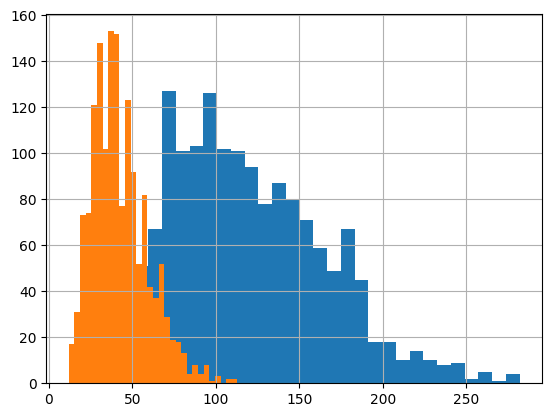

In [24]:
df_clean["air_travel_time_min"].hist(bins=30)
df_clean["airport_travel_time_min"].hist(bins=30)

In [25]:
df_clean["airport_travel_time_min"].describe()

count       1539.0
mean     42.807667
std      16.663133
min           12.0
25%           31.0
50%           40.0
75%           52.0
max          113.0
Name: airport_travel_time_min, dtype: Float64

In [26]:
print(f"Skewness of airport travel time: {df_clean['airport_travel_time_min'].skew()}")

Skewness of airport travel time: 0.8348888723225518


We can see that the airport travel times (time it takes to get to the airport) are roughly normal distributed, but not very symmetric therefore positively skewed with a mean of 42.8 minutes and a standard deviation of 16.7 minutes ranging from 12 to 113 minutes. One can also see they deviate from the air travel times, therefore the airport travel times are mostly longer than the air travel times.

As these times are skewed I try to use different measurement of position of this distribution.

### More advanced approximation of airport travel times contribution

In [27]:
# Calculate trimmed mean
print(f"Trimmed mean of airport travel time: {trim_mean(df_clean['airport_travel_time_min'], 0.1)}")

Trimmed mean of airport travel time: 41.46715328467153


Although the distribution of airport travel times can be reasonably approximated using the median or trimmed mean, these absolute values still do not account for the underlying flight duration. For this reason, analysing the relative contribution of airport access (airport_travel_time / total_travel_time) provides a more meaningful measure, and the mean access ratio offers a better indicator of how relevant airport access times are in the context of total air travel.

<Axes: >

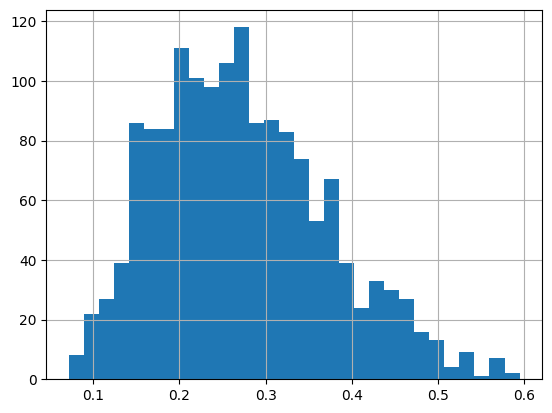

In [28]:
df_clean["access_ratio"] = (
        df_clean["airport_travel_time_min"]
        / df_clean["total_travel_time_min"]
)

df_clean["access_ratio"].hist(bins=30)

In [29]:
df_clean["access_ratio"].describe()

count      1539.0
mean     0.272646
std        0.0986
min      0.071429
25%      0.197452
50%      0.264045
75%      0.335094
max      0.594595
Name: access_ratio, dtype: Float64

In [30]:
# Correlation between airport travel time and flight time
corr_abs = df_clean["airport_travel_time_min"].corr(df_clean["air_travel_time_min"])

# Correlation between access ratio and flight time
corr_ratio = df_clean["access_ratio"].corr(df_clean["air_travel_time_min"])

print("Correlation (absolute airport travel time vs air travel time):", corr_abs)
print("Correlation (access ratio vs air travel time):", corr_ratio)

Correlation (absolute airport travel time vs air travel time): 0.07856630743380548
Correlation (access ratio vs air travel time): -0.6399502181385757


The correlation between airport travel times (both in absolute and relative terms) and air travel time is very weak, indicating that airport access duration is largely independent of the underlying flight duration. Although the distribution of access ratios is roughly normal with a mean of 27.3 % and a standard deviation of 1 %, using only absolute travel times as an estimate may be insufficient. A more meaningful approximation can be obtained by analysing relative contributions or by grouping observations by country, where systematic differences are likely to exist because of national infrastructure.

### Analysis by Country

To do so we need to add the country information to the data set from the airport data set.

In [31]:
# Extract IATA → ISO country mapping from the global airport data
iata_to_country = df_airports_global_raw.set_index("iata_code")["iso_country"].to_dict()

# Map origin and destination IATA codes to countries ISO 
df_clean["origin_country"] = df_clean["origin_iata"].map(iata_to_country)
df_clean["destination_country"] = df_clean["destination_iata"].map(iata_to_country)

Since we have the country information now, we can proceed with the analysis by country. But from here on we have two options, since we may have more than one country for an airport:

- we could assume that this flight sample represents the distribution of flight taken from each airport in a country and assume that the distribution of airport travel times aggregate by distribution of aggregated flights in a country

- or we take only one measure per airport and aggregate over all unique airports in on country, assuming that if an airport in this data set is not part of a flight pair that these airports does contribute to the represantive airports for a given country (assume completeness of the data)

I will proceed with the secound option, since it makes less assumption on the data and I assume that big airports are well known and probably part of the data.

In [32]:
# 1. Collect all airports with their travel times

# only Origin
origin_airports = (
    df_clean[["origin_iata", "origin_travel_time_min"]]
    .rename(columns={"origin_iata": "iata", "origin_travel_time_min": "travel_time"})
).copy()

# only Destination
destination_airports = (
    df_clean[["destination_iata", "destination_travel_time_min"]]
    .rename(columns={"destination_iata": "iata", "destination_travel_time_min": "travel_time"})
).copy()

# 2. combine both and drop duplicates
all_airports = pd.concat([origin_airports, destination_airports], ignore_index=True)
all_airports_unique = all_airports.drop_duplicates(subset=["iata"]).copy()

# 3. Mappe IATA codes to countries and compute country stats
all_airports_unique["country"] = all_airports_unique["iata"].map(iata_to_country)

country_stats = (
    all_airports_unique
    .groupby("country")["travel_time"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .sort_values("mean")
)

country_stats

,count,mean,median,std,min,max
country,,,,,,
LT,1,7.0,7.0,<NA>,7,7
CH,2,8.5,8.5,2.12132,7,10
BE,1,10.0,10.0,<NA>,10,10
AT,3,10.333333,11.0,5.033223,5,15
NL,1,15.0,15.0,<NA>,15,15
DK,2,15.5,15.5,6.363961,11,20
ES,4,17.0,19.5,5.354126,9,20
SE,1,18.0,18.0,<NA>,18,18
DE,11,18.636364,17.0,10.929526,5,40


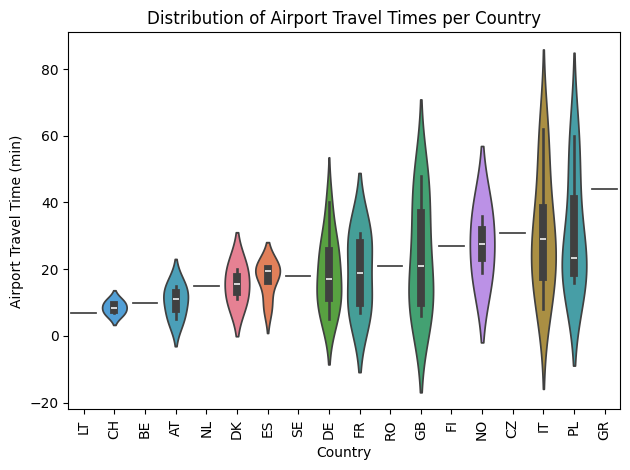

In [33]:
# Sort countries by mean travel time
order = country_stats["mean"].sort_values().index

sns.violinplot(
    data=all_airports_unique,
    x="country",
    y="travel_time",
    order=order,
    hue="country"
)

plt.xticks(rotation=90)
plt.title("Distribution of Airport Travel Times per Country")
plt.ylabel("Airport Travel Time (min)")
plt.xlabel("Country")
plt.tight_layout()
plt.show()

Based on the country-level distributions, we observe a clear and interpretable pattern: although some countries include only a single airport in our dataset, most major airports of each country are probably represented. This makes the country-based aggregation a reasonable approximation layer.

Despite the visible spread within countries which may reflects differences in local infrastructure and city-airport distances the overall trend across countries is stable and systematic. Therefore, using country-specific average access times provides a meaningful and practical proxy, especially compared to global or ratio-based approaches.

## Conclusion

Using the airport-city access times available in the dataset, we estimated typical travel times between a citys central rail station and its nearest major airport by aggregating access times at the country level. This aggregation provides a stable and interpretable approximation layer, since airports within the same country tend to share similar transport infrastructure and access characteristics.

Across the 17 European countries covered by the data, typical access times range from 7 to 44 minutes per direction, with systematic differences between countries. For incorporating airport access into air-travel-time comparisons, I therefore recommend using:

$$
T_\text{air,total} = T_\text{flight} + T_\text{access(origin country)} + T_\text{access(destination country)}
$$

The country-level mean access time serves as a reasonable estimator for this purpose, though median values provide a similarly robust alternative, given the moderate skewness observed. Overall, the country-based approximation offers a practical and data-consistent solution for estimating airport access times within the scope of this exercise.

## Interpretation & Limitations

To estimate typical travel times between a citys central railway station and its nearest major airport, several methodological challenges had to be resolved.

The original flight dataset contained a mixture of IATA codes and airport names. We therefore implemented a fuzzy-matching procedure to map all origin and destination entries to IATA codes, accepting that this probabilistic mapping may be imperfect in a few cases but recovers a substantial and representative subset of airports. After merging the flights with the airport-rail access dataset, some airports still lacked city-airport travel times, because they were not covered in the ARA data. To identify which missing values would be most impactful to resolve, we performed a bottleneck analysis on the IATA codes with missing access times. This analysis highlights a small set of frequently used airports for which access times could be obtained from external sources (e.g. a mapping or distance API) if higher data completeness were required, but doing so would go beyond the scope of this exercise.

After assigning IATA codes, we merged the flight dataset with the airport-city travel time data and computed total travel times. Three strategies were evaluated to incorporate airport access time into total air travel duration:

1. Using absolute access times directly (origin + destination):
- Advantage: Uses real airport-level information; statistically well-behaved (roughly normal).
- Limitation: Not generalizable to all airports.

2. Using the ratio of access time to total travel time:
- Advantage: Scale-invariant.
- Limitation: Access time and flight duration are uncorrelated, making ratio-based corrections unreliable.

3. Aggregating access times at the country level:
- Advantage: Reduces noise and offers a generalizable proxy when airport-level data is missing.
- Limitation: Countries differ in infrastructure; some countries in the dataset contain only one major airport.

After extracting ISO-country codes from the global airport dataset, we constructed a country-level aggregation based on unique airports, rather than using all flights. This approach avoids frequency bias (i.e., heavily sampled routes do not dominate the estimate) and provides a more stable approximation of a countrys typical airport access time. The resulting violin plots reveal clear and systematic differences between countries. Although some countries show substantial spread, likely due to varying airport-city locations, the cross-country trend is well-structured and provides a meaningful approximation layer.

## Appendix: 
### Compare to unidirectional data set

Since we have a different unseen data set we can also compare the results to the unidirectional data set and analyse if the measure is also suitable for this data set. For this the same method as above was applied.

In [34]:
# Alternative_Rail_Routes_Unidirectional.xlsx
df_ARRU = pd.read_excel("../Data/Alternative_Rail_Routes_Unidirectional.xlsx")

# Rename columns for easier access
df_ARRU = df_ARRU.rename(columns={
    "Origin": "origin",
    "Destination": "destination",
    "Valued Air Travel Time_MIN": "air_travel_time_min"
})[["origin", "destination", "air_travel_time_min"]]

# Generate new columns with IATA codes using enhanced function
df_ARRU["origin_iata"] = df_ARRU["origin"].apply(get_iata)
df_ARRU["destination_iata"] = df_ARRU["destination"].apply(get_iata)

# Cleaning ARRU data to final format
df_ARRU_clean = df_ARRU[
    (df_ARRU["origin_iata"] != "unknown") &
    (df_ARRU["destination_iata"] != "unknown")
    ].copy()

# Join ARRU with ARA to get city-airport times for origin
dfU_joined = df_ARRU_clean.merge(
    df_ARA_final_clean,
    left_on="origin_iata",
    right_on="iata_code",
    how="left"
).rename(columns={"city_airport_time_min": "origin_travel_time_min"}).drop(columns=["iata_code"])

# Join again to get city-airport times for destination
dfU_joined = dfU_joined.merge(
    df_ARA_final_clean,
    left_on="destination_iata",
    right_on="iata_code",
    how="left"
).rename(columns={"city_airport_time_min": "destination_travel_time_min"}).drop(columns=["iata_code"])

# Airport travel time
dfU_joined["airport_travel_time_min"] = (
        dfU_joined["origin_travel_time_min"] +
        dfU_joined["destination_travel_time_min"]
)

# Drop rows without both access times
dfU_clean = dfU_joined.dropna(subset=["origin_travel_time_min", "destination_travel_time_min"])

# Map origin and destination IATA codes to countries ISO
dfU_clean["origin_country"] = dfU_clean["origin_iata"].map(iata_to_country)
dfU_clean["destination_country"] = dfU_clean["destination_iata"].map(iata_to_country)

# Collect all airports with their travel times
origin_airports_U = dfU_clean[["origin_iata", "origin_travel_time_min"]].rename(
    columns={"origin_iata": "iata", "origin_travel_time_min": "travel_time"}
)

dest_airports_U = dfU_clean[["destination_iata", "destination_travel_time_min"]].rename(
    columns={"destination_iata": "iata", "destination_travel_time_min": "travel_time"}
)

# Combine both and drop duplicates
all_airports_U = pd.concat([origin_airports_U, dest_airports_U])
all_airports_U = all_airports_U.drop_duplicates(subset="iata").copy()

# Map IATA codes to countries and compute country stats
all_airports_U["country"] = all_airports_U["iata"].map(iata_to_country)

C:\Users\Meliha\AppData\Local\Temp\ipykernel_13952\87027762.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfU_clean["origin_country"] = dfU_clean["origin_iata"].map(iata_to_country)
C:\Users\Meliha\AppData\Local\Temp\ipykernel_13952\87027762.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfU_clean["destination_country"] = dfU_clean["destination_iata"].map(iata_to_country)


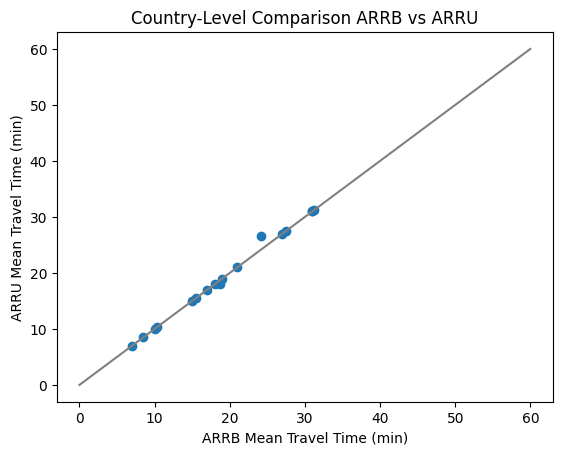

In [35]:
# Compare country-level stats between ARRB and ARRU
country_stats_U = (
    all_airports_U
    .groupby("country")["travel_time"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .sort_values("mean")
)

df_compare = country_stats.join(
    country_stats_U,
    lsuffix="_ARRB",
    rsuffix="_ARRU",
    how="inner"
)

df_compare[["mean_ARRB", "mean_ARRU"]]

plt.scatter(df_compare["mean_ARRB"], df_compare["mean_ARRU"])
plt.xlabel("ARRB Mean Travel Time (min)")
plt.ylabel("ARRU Mean Travel Time (min)")
plt.plot([0, 60], [0, 60], color="gray")  # identity line
plt.title("Country-Level Comparison ARRB vs ARRU")
plt.show()

### Interpretation

To assess the robustness of the country-level access-time approximation, we repeated the same procedure on the Alternative Rail Routes Unidirectional dataset, using identical preprocessing steps and country-level aggregation.

The resulting distributions closely match those of the bidirectional dataset (ARRB). This is confirmed by the comparison of country-level mean access times, where values from both datasets lie close to the 45-degree identity line, with only moderate deviations.

Although both datasets share a common data source and are therefore not fully independent, their differing sampling directions and route compositions indicate that the consistency of results is not driven by a specific flight sample. Instead, the country-level aggregation generalizes well and provides a robust proxy for estimating typical airport access times across countries.

# Q2: Are there any routes on which rail leads to shorter journey times than air travel?

\
(Author Tim Krueger) \
We will mainly focus on the `Alternative_Rail_Routes_Unidirectional` because it contains all routes and information that we need. (BRUNO 2025)\
**TLDR - YES one route Stuttgart-FRA**

## How did we derive routes where rail is faster than air
$\newline$
This is done via the already integrated columns `Service Time Difference` and `Theoretical Time Difference`

1. **Theoretical Time Difference**
    - It represents the time gain or loss a passenger would experience (in terms of perceived utility) if they switched from the air route to the best possible theoretical rail option.
    - Formula: \
    $T_{Theoretical Time Difference} = T_{Valued Air Travel Time} - T_{Rail Theoretical Travel Time}$
2. **Service Time Difference**
    - It represents the time gain or loss based on currently scheduled commercial rail services.
    - Formula: \
    $T_{Service Time Difference} = T_{Valued Air Travel Time} - T_{Rail Service Travel Time}$


**Note:** \
Both calculations use the Valued Air Travel Time (Air Travel Time $\times$ 1.62) rather than the raw flight duration. This accounts for the higher "disutility" (stress, discomfort, processing time) passengers typically associate with air travel compared to rail (BRUNO 2025).

In [36]:
# Valued Air travel Time - Rail Theoretical Travel Time
faster_rail_theoretical_valued = Alternative_Rail_Routes_Unidirectional[
    Alternative_Rail_Routes_Unidirectional['Theoretical Time Difference'] > 0]
num_faster_rail_theoretical_valued = len(faster_rail_theoretical_valued)

# Valued Air travel Time - Rail Service Travel Time
faster_rail_service_valued = Alternative_Rail_Routes_Unidirectional[
    Alternative_Rail_Routes_Unidirectional['Service Time Difference'] > 0]
num_faster_rail_service_valued = len(faster_rail_service_valued)

examples = faster_rail_service_valued[
    ['Route Name', 'Origin', 'Destination', 'Rail Service Travel Time',
     'Valued Air Travel Time', 'Service Time Difference', 'Air Travel Time']]

print(f"Number of routes where Rail Service is faster than Valued Air: {num_faster_rail_service_valued}")
print(f"Number of routes where Rail Theoretical is faster than Valued Air: {num_faster_rail_theoretical_valued}")
print("Examples where Rail Service is faster than Valued Air:")
examples

Number of routes where Rail Service is faster than Valued Air: 1
Number of routes where Rail Theoretical is faster than Valued Air: 35
Examples where Rail Service is faster than Valued Air:


,Route Name,Origin,Destination,Rail Service Travel Time,Valued Air Travel Time,Service Time Difference,Air Travel Time
6373,Stuttgart-FRA,Stuttgart,Frankfurt Airport,71.0,81.0,10.0,50.0


## Check out route details

In [37]:
Candidate_Rail_Routes.loc[
    (Candidate_Rail_Routes['Origin'] == 'Stuttgart') & (Candidate_Rail_Routes['Destination'] == 'Frankfurt Airport')]

,Airport OD,Origin,Destination,Origin Coordinates,Destination Coordinates,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode
2117,STR-FRA,Stuttgart,Frankfurt Airport,"48.784081,9.181636","50.052932,8.569915","Schnellfahrstrecke Mannheim–Stuttgart, Main-Ne...","182.1 km, 1 h 11 min",01:11:00,182.1 km,1h 11min,Train


This is one of Germany's fastest and newest high-speed ICE (Inter City Express) routes. Renovated in 2020 and saves up to 17 minutes according to DB and the government of Baden-Württemberg. ([text](https://vm.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/deutsche-bahn-schnellfahrstrecke-mannheim-stuttgart-geht-puenktlich-wieder-in-betrieb))

## Check out theoretically faster rail routes

In [38]:
faster_rail_theoretical_valued.sort_values(by='Theoretical Time Difference', ascending=False)[
    ['Route Name', 'Origin', 'Destination', 'Rail Theoretical Travel Time',
     'Valued Air Travel Time', 'Theoretical Time Difference']].head()

,Route Name,Origin,Destination,Rail Theoretical Travel Time,Valued Air Travel Time,Theoretical Time Difference
1683,Brussels-CDG,Brussels,Charles de Gaulle International Airport,64.0,101.690722,37.690722
1820,CDG-Brussels,Charles de Gaulle International Airport,Brussels,64.0,96.382569,32.382569
2482,Düsseldorf-FRA,Düsseldorf,Frankfurt Airport,55.0,81.009147,26.009147
2741,FRA-Düsseldorf,Frankfurt Airport,Düsseldorf,55.0,80.186343,25.186343
4109,LYS-Marseille,Lyon Saint-Exupéry Airport,Marseille,66.0,90.846879,24.846879


## Explore faster routes

- Display routes on map to get a sense of space and where a bulk of fast routes is positioned
- Show descriptive analysis of faster rail routes and analyze them by country

In [39]:
# for this we need convert coordinates to readable format

faster_rail_theoretical_valued = faster_rail_theoretical_valued.copy()


def split_coords(coord_str):
    lat_str, lon_str = coord_str.split(',')
    return float(lat_str.strip()), float(lon_str.strip())


faster_rail_theoretical_valued['origin_lat'] = faster_rail_theoretical_valued['Origin Coordinates'].map(
    lambda x: split_coords(x)[0])
faster_rail_theoretical_valued['origin_lon'] = faster_rail_theoretical_valued['Origin Coordinates'].map(
    lambda x: split_coords(x)[1])
faster_rail_theoretical_valued['dest_lat'] = faster_rail_theoretical_valued['Destination Coordinates'].map(
    lambda x: split_coords(x)[0])
faster_rail_theoretical_valued['dest_lon'] = faster_rail_theoretical_valued['Destination Coordinates'].map(
    lambda x: split_coords(x)[1])

In [40]:
# We also need to merge them with Candidate_Rail_Routes to get raw travel times and distances

full_info_faster_rail_theoretical_valued = faster_rail_theoretical_valued.merge(
    Candidate_Rail_Routes.drop_duplicates(subset=['Origin', 'Destination']),
    on=['Origin', 'Destination'],
    how='left'
)


# The travel times a currently in a string format (1h 12min) this needs to converted to time delta

def parse_row(time_str):
    if pd.isna(time_str) or time_str == "" or time_str == "nan":
        return pd.NaT

    clean_str = time_str.split(',')[-1]

    hours_match = re.search(r'(?i)(\d+)\s*h', clean_str)
    mins_match = re.search(r'(?i)(\d+)\s*min', clean_str)

    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(mins_match.group(1)) if mins_match else 0

    if hours == 0 and minutes == 0:
        return pd.NaT
    return pd.Timedelta(hours=hours, minutes=minutes)


full_info_faster_rail_theoretical_valued['Distance'] = full_info_faster_rail_theoretical_valued['Distance'].str[
    :-3].astype(float)
full_info_faster_rail_theoretical_valued['Theoretical Travel Time'] = full_info_faster_rail_theoretical_valued[
    'Distance and Theoretical Time'].apply(parse_row)
full_info_faster_rail_theoretical_valued['Service Travel Time'] = full_info_faster_rail_theoretical_valued[
    'Service Travel Time'].apply(parse_row)
full_info_faster_rail_theoretical_valued['Travel Time Delta'] = full_info_faster_rail_theoretical_valued[
                                                                    'Service Travel Time'] - \
                                                                full_info_faster_rail_theoretical_valued[
                                                                    'Theoretical Travel Time']


In [41]:
# Lets take a quick look a the result of the transformation steps
full_info_faster_rail_theoretical_valued.head()

,Route Name,Origin,Destination,Origin Coordinates_x,Destination Coordinates_x,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Airport OD,Origin Coordinates_y,Destination Coordinates_y,Route,Distance and Theoretical Time,Theoretical Travel Time,Distance,Service Travel Time,Mode,Travel Time Delta
0,AMS-BRU,Amsterdam Airport Schiphol,Brussels Airport,"52.309523,4.762181","50.898344,4.482370",66.0,131.0,45.417818,73.576865,64.039123,...,AMS-BRU,"52.309523,4.762181","50.898344,4.482370","HSL-Zuid, L25","185.8 km, 1 h 6 min",0 days 01:06:00,185.8,0 days 02:11:00,Train,0 days 01:05:00
1,AMS-Brussels,Amsterdam Airport Schiphol,Brussels,"52.309523,4.762181","50.835374,4.335695",73.0,99.0,45.417818,73.576865,64.039123,...,AMS-BRU,"52.309523,4.762181","50.835374,4.335695","HSL-Zuid, L25","195.1 km, 1 h 13 min",0 days 01:13:00,195.1,0 days 01:39:00,Train,0 days 00:26:00
2,BRU-AMS,Brussels Airport,Amsterdam Airport Schiphol,"50.898344,4.482370","52.309523,4.762181",66.0,145.0,55.968188,90.668465,78.915145,...,BRU-AMS,"50.898344,4.482370","52.309523,4.762181","L25, HSL-Zuid","185.8 km, 1 h 6 min",0 days 01:06:00,185.8,0 days 02:25:00,Train,0 days 01:19:00
3,BRU-Amsterdam,Brussels Airport,Amsterdam,"50.898344,4.482370","52.37919,4.899426",77.0,163.0,55.968188,90.668465,78.915145,...,BRU-AMS,"50.898344,4.482370","52.37919,4.899426","L25, HSL-Zuid","202.7 km, 1 h 17 min",0 days 01:17:00,202.7,0 days 02:43:00,Train,0 days 01:26:00
4,BRU-CDG,Brussels Airport,Charles de Gaulle International Airport,"50.898344,4.482370","49.003989,2.571154",78.0,190.0,62.772050,101.690722,88.508591,...,BRU-CDG,"50.898344,4.482370","49.003989,2.571154","L1, Ligne de Gonesse à Lille-Frontière (LGV)","306.5 km, 1 h 18 min",0 days 01:18:00,306.5,0 days 03:10:00,Train,0 days 01:52:00


We now will use folium to place all hubs, origin train stations, destination train stations and connecting routes on the open street map.  
- hubs $\rightarrow$ incoming and outgoing routes, (indicated by the left and right arrow)
- origin train stations, (indicated by green train)
- destination train stations, (indicated by red home)
- routes are indicated by blue lines

In [42]:
all_origins = set(full_info_faster_rail_theoretical_valued['Origin'])
all_destinations = set(full_info_faster_rail_theoretical_valued['Destination'])
hub_stations = all_origins.intersection(all_destinations)

m = folium.Map(location=[50.8503, 4.3517], zoom_start=6, tiles='CartoDB positron')
routes_layer = FeatureGroup(name="Connections")
stations_layer = FeatureGroup(name="Stations")

plotted_cities = set()
tooltip_style = "font-size: 14px; font-weight: bold; white-space: nowrap;"


def add_station_marker(name, coords, role_color, role_icon, role_label):
    """Adds a marker if the station hasn't been plotted yet."""
    if name in plotted_cities:
        return

    if name in hub_stations:
        color, icon, label_suffix = 'purple', 'exchange', 'Hub'
    else:
        color, icon, label_suffix = role_color, role_icon, role_label

    folium.Marker(
        location=coords,
        tooltip=folium.Tooltip(f"{name} ({label_suffix})", style=tooltip_style),
        icon=folium.Icon(color=color, icon=icon, prefix='fa')
    ).add_to(stations_layer)

    plotted_cities.add(name)


for _, row in full_info_faster_rail_theoretical_valued.iterrows():
    p1 = (row['origin_lat'], row['origin_lon'])
    p2 = (row['dest_lat'], row['dest_lon'])

    info_text = (f"{row['Origin']} to {row['Destination']}: "
                 f"Rail {row['Rail Theoretical Travel Time']} min, "
                 f"Air {round(row['Valued Air Travel Time'], 2)} min, "
                 f"Distance {row['Distance']} km")

    folium.PolyLine(
        locations=[p1, p2],
        color='blue', weight=2, opacity=0.5,
        tooltip=folium.Tooltip(info_text, style=tooltip_style)
    ).add_to(routes_layer)

    add_station_marker(row['Origin'], p1, 'green', 'train', 'Origin')
    add_station_marker(row['Destination'], p2, 'red', 'home', 'Destination')

routes_layer.add_to(m)
stations_layer.add_to(m)
LayerControl().add_to(m)

m.save("map_osm.html")
print("Map saved as 'map_osm.html'. Open this file in your browser.")
m

Map saved as 'map_osm.html'. Open this file in your browser.


Initial thought: France has a lot of fast rail routes.\
Explanation: This is because France implemented a ban on certain short-haul domestic flights when a train alternative of 2.5 hours or less exists.

## Descriptive analysis of faster routes

Exploration of infrastructure Potential vs. operational reality by country

In [43]:
analysis_df = full_info_faster_rail_theoretical_valued.copy()
num_routes = len(analysis_df)
routes_service_faster = analysis_df[analysis_df['Service Time Difference'] > 0]
num_service_faster = len(routes_service_faster)
pct_service_faster = (num_service_faster / num_routes) * 100
print(f"Routes where Current Rail Service is faster than Valued Air: {num_service_faster} ({pct_service_faster:.1f}%)")

Routes where Current Rail Service is faster than Valued Air: 1 (2.9%)


### Descriptive Stats on Time Differences

In [44]:
print("\nDescriptive Statistics for Time Differences (Minutes):")
analysis_df[['Theoretical Time Difference', 'Service Time Difference', "Distance", "Theoretical Travel Time",
             'Service Travel Time', 'Travel Time Delta']].describe()


Descriptive Statistics for Time Differences (Minutes):


,Theoretical Time Difference,Service Time Difference,Distance,Theoretical Travel Time,Service Travel Time,Travel Time Delta
count,35.000000,34.000000,35.000000,35,34,34
mean,14.367565,-47.362800,309.217143,0 days 01:22:30.857142857,0 days 02:24:14.117647058,0 days 01:02:07.058823529
std,9.605683,33.989444,103.932030,0 days 00:17:57.189620722,0 days 00:39:52.308530886,0 days 00:34:14.109745101
min,0.100000,-110.370909,182.100000,0 days 00:55:00,0 days 01:11:00,0 days 00:00:00
25%,8.119330,-73.585243,208.600000,0 days 01:06:00,0 days 01:53:15,0 days 00:33:30
50%,13.668465,-50.050616,306.500000,0 days 01:18:00,0 days 02:20:30,0 days 00:57:30
75%,21.195858,-16.329323,411.600000,0 days 01:38:00,0 days 02:56:45,0 days 01:31:15
max,37.690722,10.000000,487.100000,0 days 01:52:00,0 days 03:44:00,0 days 02:02:00


### Passenger Flows

In [45]:
print(f"Total Annual Passenger Flow on these routes: {analysis_df['Passenger Flows'].sum():,}")

Total Annual Passenger Flow on these routes: 1,716,319


### Top 5 Routes by Theoretical Time Difference (Best Potential)

In [46]:
analysis_df.sort_values(by='Theoretical Time Difference', ascending=False)[
    ['Route Name', 'Theoretical Time Difference', 'Service Time Difference']].head(5)

,Route Name,Theoretical Time Difference,Service Time Difference
8,Brussels-CDG,37.690722,-5.309278
10,CDG-Brussels,32.382569,-68.617431
18,Düsseldorf-FRA,26.009147,-0.990853
21,FRA-Düsseldorf,25.186343,-73.813657
25,LYS-Marseille,24.846879,-10.153121


### Top 5 Routes by Service Time Difference

In [47]:
analysis_df.sort_values(by='Service Time Difference', ascending=False)[
    ['Route Name', 'Theoretical Time Difference', 'Service Time Difference']].head(5)

,Route Name,Theoretical Time Difference,Service Time Difference
34,Stuttgart-FRA,10.000000,10.000000
18,Düsseldorf-FRA,26.009147,-0.990853
31,Marseille-LYS,23.338235,-1.661765
26,LYS-Paris,5.100047,-4.899953
8,Brussels-CDG,37.690722,-5.309278


### Top 5 Routes by Passenger Flow

In [48]:
analysis_df.sort_values(by='Passenger Flows', ascending=False)[
    ['Route Name', 'Passenger Flows', 'Service Time Difference', 'Theoretical Time Difference']].head(5)

,Route Name,Passenger Flows,Service Time Difference,Theoretical Time Difference
29,Lyon-CDG,237145,-14.899953,16.100047
14,CDG-Lyon,190573,-74.514831,9.485169
34,Stuttgart-FRA,164025,10.000000,10.000000
28,London-CDG,136099,-51.201232,15.798768
21,FRA-Düsseldorf,120161,-73.813657,25.186343


These are routes where rail could be significantly faster but currently lags behind:

- Brussels-CDG:
    - Potential: Rail could be 37 minutes faster.
    - Reality: Rail is currently 5 minutes slower.
- Lyon-CDG (High Volume):
    - This route has the highest passenger flow (237,145).
    - Potential: Rail could save 16 minutes.
    - Reality: Rail currently loses 15 minutes.
    - Implication: Closing the operational gap on this single route could shift massive passenger volumes to rail.

### Histogram of Theoretical vs Service Time Difference

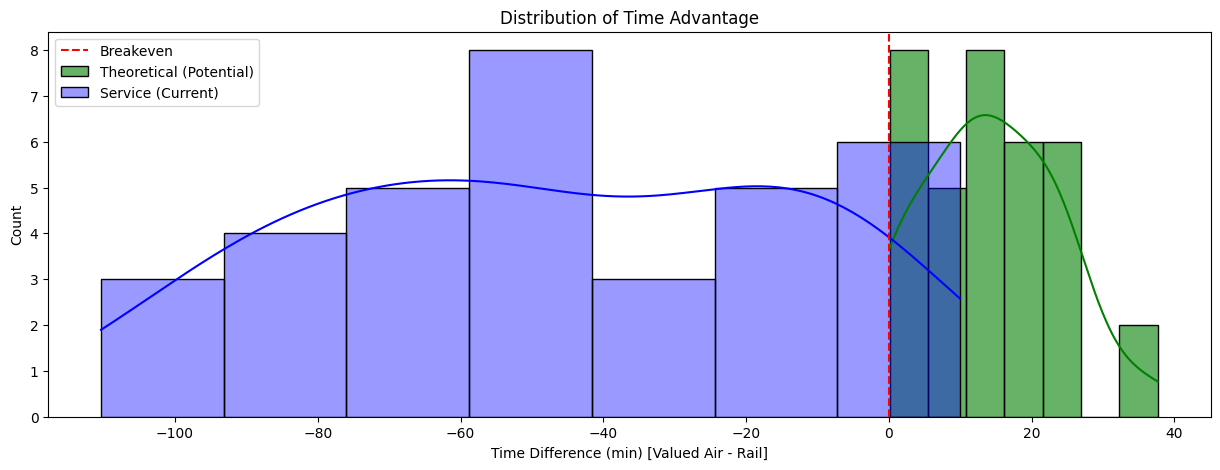

In [49]:
plt.figure(figsize=(15, 5))
sns.histplot(analysis_df['Theoretical Time Difference'], color='green', label='Theoretical (Potential)', kde=True,
             alpha=0.6)
sns.histplot(analysis_df['Service Time Difference'], color='blue', label='Service (Current)', kde=True, alpha=0.4)
plt.axvline(0, color='red', linestyle='--', label='Breakeven')
plt.xlabel("Time Difference (min) [Valued Air - Rail]")
plt.title("Distribution of Time Advantage")
plt.legend()

## Analysis by country
\
We load a country <-> airport mapping file and analyze routes by country:\
We are interested in:
- Total endpoints by country
- Domestic vs International routes

\
**note**\
Mapping file was created by Gemini 3 Pro

In [50]:
# Load mapping and apply

map_df = pd.read_csv(os.path.join(data_path, 'Airport_Country_Map.csv', ))
exact_matches = map_df[map_df['Type'] == 'Exact Match'].set_index('Airport_Name')['Country'].to_dict()
keyword_matches = map_df[map_df['Type'] == 'Keyword Match'][['Airport_Name', 'Country']].values.tolist()


# helper function
def get_country_from_map(name):
    if not isinstance(name, str):
        return "Unknown"
    name = name.strip()
    if name in exact_matches:
        return exact_matches[name]
    for keyword, country in keyword_matches:
        if keyword in name:
            return country

    return "Unknown"


analysis_df['Origin Country'] = analysis_df['Origin'].apply(get_country_from_map)
analysis_df['Destination Country'] = analysis_df['Destination'].apply(get_country_from_map)

unknowns = analysis_df[(analysis_df['Origin Country'] == 'Unknown') | (analysis_df['Destination Country'] == 'Unknown')]
if not unknowns.empty:
    print("Warning: Some locations still unknown:")
    print(unknowns[['Origin', 'Destination']].head())

In [51]:
country_counts = collections.Counter()
for index, row in analysis_df.iterrows():
    country_counts[row['Origin Country']] += 1
    country_counts[row['Destination Country']] += 1

country_stats = pd.DataFrame.from_dict(country_counts, orient='index', columns=['Total Endpoints']).sort_values(
    'Total Endpoints', ascending=False)

analysis_df['Type'] = analysis_df.apply(
    lambda x: 'Domestic' if x['Origin Country'] == x['Destination Country'] else 'International', axis=1)

domestic_stats = analysis_df[analysis_df['Type'] == 'Domestic']['Origin Country'].value_counts().to_frame(
    name='Domestic Routes')

final_stats = country_stats.join(domestic_stats).fillna(0)
final_stats['Domestic Routes'] = final_stats['Domestic Routes'].astype(int)

print("Country Analysis Results:")
print(final_stats)

print("\nTop 3 Countries Breakdown:")
top_3 = final_stats.head(3).index.tolist()
for country in top_3:
    print(f"--- {country} ---")
    involved_routes = analysis_df[
        (analysis_df['Origin Country'] == country) | (analysis_df['Destination Country'] == country)]
    print(f"Total Routes Involved: {len(involved_routes)}")

    domestic_routes = analysis_df[
        (analysis_df['Origin Country'] == country) & (analysis_df['Destination Country'] == country)]
    print(f"Domestic Routes: {len(domestic_routes)}")
    if not domestic_routes.empty:
        print(f"Examples: {domestic_routes['Origin'].tolist()[:3]} -> {domestic_routes['Destination'].tolist()[:3]}")

    international_routes = analysis_df[
        ((analysis_df['Origin Country'] == country) & (analysis_df['Destination Country'] != country)) | (
                (analysis_df['Origin Country'] != country) & (analysis_df['Destination Country'] == country))]
    print(f"International Routes: {len(international_routes)}")
    other_countries = set(
        international_routes['Origin Country'].tolist() + international_routes['Destination Country'].tolist())
    if country in other_countries: other_countries.remove(country)
    print(f"Connected to: {', '.join(other_countries)}")

Country Analysis Results:
                Total Endpoints  Domestic Routes
France                       28                9
Germany                      15                7
Belgium                      13                0
Netherlands                   5                0
United Kingdom                4                0
Italy                         4                2
Luxembourg                    1                0

Top 3 Countries Breakdown:
--- France ---
Total Routes Involved: 19
Domestic Routes: 9
Examples: ['Charles de Gaulle International Airport', 'Charles de Gaulle International Airport', 'Charles de Gaulle International Airport'] -> ['Lyon Saint-Exupéry Airport', 'Lyon', 'Rennes']
International Routes: 10
Connected to: United Kingdom, Germany, Luxembourg, Belgium
--- Germany ---
Total Routes Involved: 8
Domestic Routes: 7
Examples: ['Düsseldorf Airport', 'Düsseldorf Airport', 'Düsseldorf'] -> ['Frankfurt Airport', 'Frankfurt am Main', 'Frankfurt Airport']
International Routes: 

- International Dominance: Belgium's data consists entirely of international routes (13), connecting primarily to France, the UK, and the Netherlands. This highlights the complexity of cross-border rail efficiency.
- Domestic Strength: France has a strong mix of domestic routes (9 out of 19 routes), suggesting that domestic high-speed rail (TGV) is a primary driver of the potential time savings observed in the data.

### Dumbbell Plot -> explore the gap between Potential, current, and air travel times

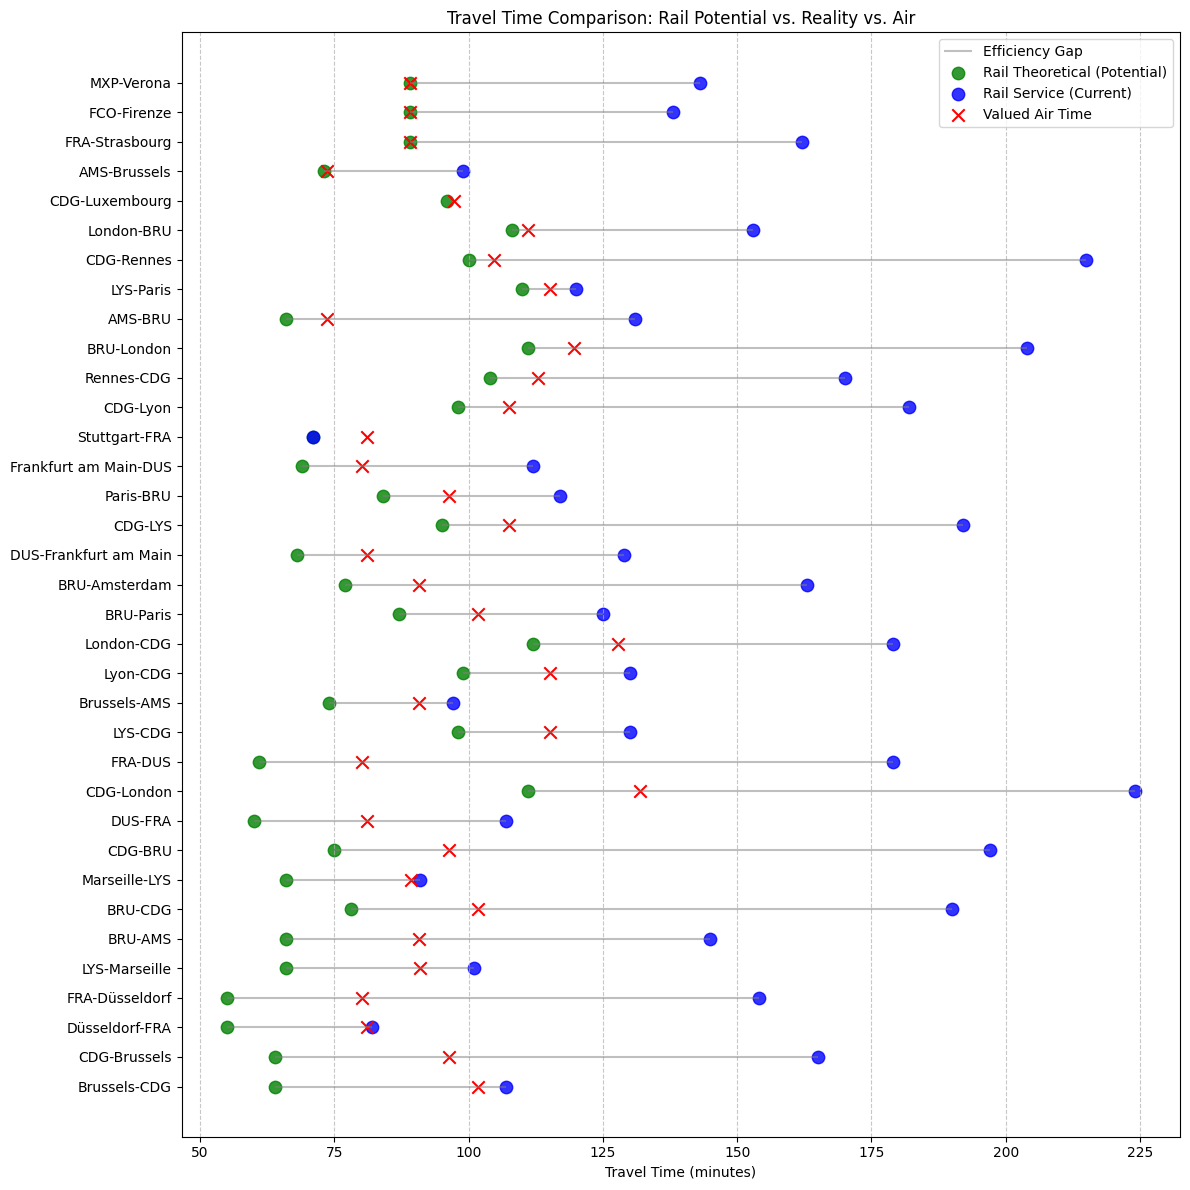

In [52]:
plot_df = analysis_df[['Route Name', 'Origin Country', 'Rail Theoretical Travel Time', 'Rail Service Travel Time',
                       'Valued Air Travel Time', 'Theoretical Time Difference', 'Service Time Difference']].copy()
plot_df.sort_values('Theoretical Time Difference', ascending=False, inplace=True)

plt.figure(figsize=(12, 12))
plt.hlines(y=plot_df['Route Name'], xmin=plot_df['Rail Theoretical Travel Time'],
           xmax=plot_df['Rail Service Travel Time'], color='grey', alpha=0.5, label='Efficiency Gap')

plt.scatter(plot_df['Rail Theoretical Travel Time'], plot_df['Route Name'], color='green',
            label='Rail Theoretical (Potential)', s=80, alpha=0.8)
plt.scatter(plot_df['Rail Service Travel Time'], plot_df['Route Name'], color='blue', label='Rail Service (Current)',
            s=80, alpha=0.8)
plt.scatter(plot_df['Valued Air Travel Time'], plot_df['Route Name'], color='red', marker='x', label='Valued Air Time',
            s=80)

plt.xlabel('Travel Time (minutes)')
plt.title('Travel Time Comparison: Rail Potential vs. Reality vs. Air')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

### Time Difference Distribution by Country

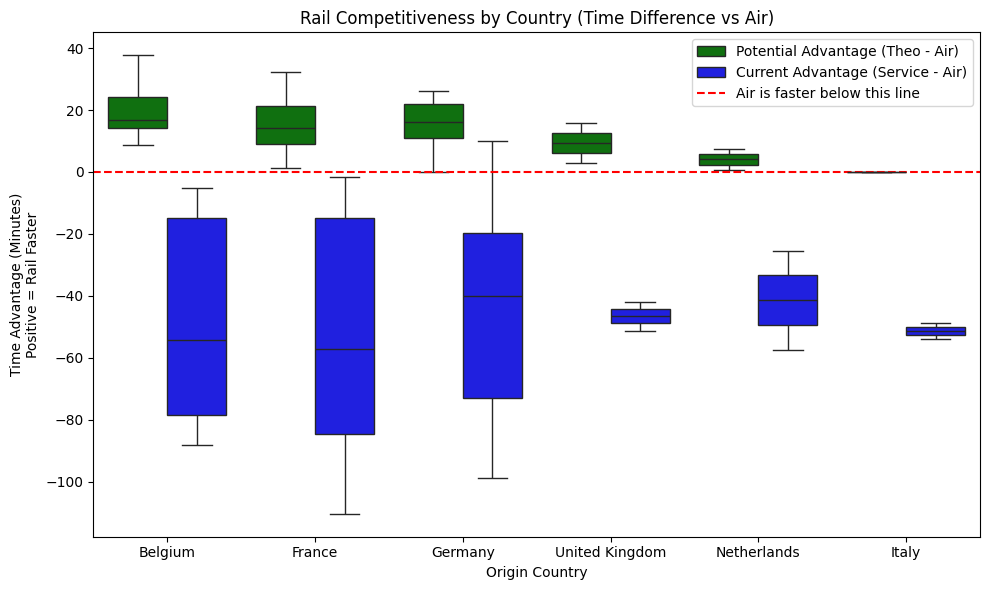

In [53]:
plt.figure(figsize=(10, 6))
melted = plot_df.melt(id_vars=['Route Name', 'Origin Country'],
                      value_vars=['Theoretical Time Difference', 'Service Time Difference'], var_name='Metric',
                      value_name='Minutes')

melted['Metric'] = melted['Metric'].replace({
    'Theoretical Time Difference': 'Potential Advantage (Theo - Air)',
    'Service Time Difference': 'Current Advantage (Service - Air)'
})

sns.boxplot(data=melted, x='Origin Country', y='Minutes', hue='Metric', palette=['green', 'blue'])
plt.axhline(0, color='red', linestyle='--', label='Air is faster below this line')
plt.title('Rail Competitiveness by Country (Time Difference vs Air)')
plt.ylabel('Time Advantage (Minutes)\nPositive = Rail Faster')
plt.legend()
plt.tight_layout()

- Belgium & France: Both show high theoretical potential (green boxes entirely above the red "Air is faster" line). However, their current service (blue boxes) has a massive spread, often dipping deep into negative territory. This suggests that while the high-speed tracks exist (e.g., TGV, Thalys), connection times or schedule buffers are eroding the speed advantage.
- Germany: Shows the most consistent potential (compact green box). Its current service (blue box) is also the most competitive, with the median value closer to the zero line than other nations, indicating reliable, competitive schedules.
- UK, Netherlands, Italy: For the routes analyzed, rail is currently uncompetitive against air, with service times significantly slower (blue boxes far below zero).

The answer to **"Are there any routes on which rail leads to shorter journey times?" is yes**, but currently very few (principally Stuttgart-FRA).

However, the "Efficiency Gap" analysis proves that speed is not the missing ingredient. The theoretical speeds (green dots) are already sufficient to beat air travel on most routes. The deficit lies in operations—likely dwell times, transfers, and scheduling buffers. Closing this gap does not necessarily require new tracks, but rather optimized timetables.

# Q3: How do rail travel times compare to air travel times between 10 to 12 big European cities by population?
\
(Author Meliha Kasapovic) \
We will mainly focus on the `Alternative_Rail_Routes_Unidirectional`, since it contains all information needed. Furthermore, additional dataset `europe-cities-by-population-2025` will be used, to provide us information regarding the biggest European cities by population in 2025 (World Population Review 2025). 

In [54]:
alt_rail_routes_unidirectional = Alternative_Rail_Routes_Unidirectional.copy()
population = pd.read_json(os.path.join(data_path, "europe-cities-by-population-2025.json"))

## Getting the biggest cities


In [55]:
population = population.sort_values(by="population", ascending=False)
population.head(12)

,city,population,country,cca2,lat,lng,slug
0,Moscow,12737400,Russia,RU,55.7522,37.61560,NaN
1,Paris,11346800,France,FR,48.8534,2.34880,NaN
2,London,9840740,United Kingdom,GB,51.5085,-0.12574,NaN
3,Madrid,6810530,Spain,ES,40.4165,-3.70256,NaN
4,Barcelona,5733250,Spain,ES,41.3888,2.15899,NaN
5,Saint Petersburg,5597340,Russia,RU,59.9386,30.31410,NaN
6,Rome,4347100,Italy,IT,41.8919,12.51130,NaN
7,Berlin,3580190,Germany,DE,52.5244,13.41050,NaN
8,Milan,3167450,Italy,IT,45.4643,9.18951,NaN
9,Athens,3155320,Greece,GR,37.9795,23.71620,NaN


In [56]:
missing_countries = population.loc[
    ~population['cca2'].isin(all_airports_unique['country']),
    'cca2'
].unique()

missing_countries

array(['RU', 'PT', 'UA', 'BY', 'HU', 'RS', 'IE', 'BG', 'HR', 'MK', 'LV',
       'XK', 'AL', 'MD', 'EE', 'SK', 'BA', 'SI', 'CY'], dtype=object)

In the `population` dataset, we can see that there are big cities in Russia and Ukraine that appear amongst the largest European cities by population. Since our dataset does not contain Ukraine and Russia, these two countries are removed from the `population` dataset. Furthermore, to match our data, city "Naples" was renamed to "Napoli".

In [57]:
# Filtering out Russia and Ukraine.
# Kyiv's airport has been closed since 2022 and Russia is not included in the dataset
population = population[
    (population["country"] != "Russia") &
    (population["country"] != "Ukraine")
    ]

# Sort by population
population = population.sort_values(by="population", ascending=False)

# Take top 12 cities
cities_df = population[["city", "population", "country"]].head(12)

# Create a Python list of city names, and renaming Naples to Napoli, to match travel data
cities = cities_df["city"].tolist()
cities = ["Napoli" if c == "Naples" else c for c in cities]
cities

['Paris',
 'London',
 'Madrid',
 'Barcelona',
 'Rome',
 'Berlin',
 'Milan',
 'Athens',
 'Lisbon',
 'Manchester',
 'Birmingham',
 'Napoli']

After sorting all cities by population, we can see that the 12 big cities in Europe that whose routes will be analyzed are: Paris, London, Madrid, Barcelona, Rome, Berlin, Milan, Athens, Lisbon, Manchester and Birmingham.

## Extracting the routes between the cities

Additinal columns `OriginCity` and `DestinationCity` are added to the Alternative_Rail_Routes_Unidirectional table by extracting names of the biggest cities from the airports' names in columns `Origin` and `Destination`. Rows that did not contain name of any of twelve cities were dropped.

In [58]:
def extract_city(value, cities):
    value = str(value).lower()
    for city in cities:
        if city.lower() in value:
            return city
    return None

In [59]:
alt_rail_routes_unidirectional["OriginCity"] = alt_rail_routes_unidirectional["Origin"].apply(
    lambda x: extract_city(x, cities))
alt_rail_routes_unidirectional["DestinationCity"] = alt_rail_routes_unidirectional["Destination"].apply(
    lambda x: extract_city(x, cities))

alt_rail_routes_unidirectional[["Origin", "OriginCity"]].drop_duplicates().head(10)

,Origin,OriginCity
0,A Coruña,None
6,Aalborg Airport,None
23,Málaga-Costa del Sol Airport,None
169,Amsterdam Airport Schiphol,None
317,Marche Airport,None
332,Stockholm-Arlanda Airport,None
460,Athens International Airport,Athens
574,Aalborg,None
580,Aarhus,None
586,Aberdeen,None


In [60]:
alt_rail_routes_unidirectional[["Destination", "DestinationCity"]].drop_duplicates().head(10)

,Destination,DestinationCity
0,Málaga-Costa del Sol Airport,None
1,Barcelona-El Prat Airport,Barcelona
2,Geneva Cointrin International Airport,None
3,London Gatwick Airport,London
4,Madrid–Barajas Airport,Madrid
5,Milan Malpensa International Airport,Milan
7,Amsterdam Airport Schiphol,None
8,Alicante,None
9,Amsterdam,None
11,Barcelona,Barcelona


Checking the dataset containing desired routes:

In [61]:
city_routes = alt_rail_routes_unidirectional[
    alt_rail_routes_unidirectional["OriginCity"].notna() &
    alt_rail_routes_unidirectional["DestinationCity"].notna()
    ].copy()

city_routes.head(5)

,Route Name,Origin,Destination,Origin Coordinates,Destination Coordinates,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Theoretical Time Difference_MAX,Service Time Difference_MAX,Theoretical Time Increase,Service Time Increase,Theoretical Time Increase_MIN,Service Time Increase_MIN,Theoretical Time Increase_MAX,Service Time Increase_MAX,OriginCity,DestinationCity
465,ATH-BCN,Athens International Airport,Barcelona-El Prat Airport,"37.936947,23.944620","41.304141,2.073126",2220.0,NaN,193.030576,312.709532,272.173112,...,-1866.754047,NaN,609.923993,NaN,715.657354,NaN,528.457306,NaN,Athens,Barcelona
466,ATH-BER,Athens International Airport,Berlin Brandenburg Airport,"37.936947,23.944620","52.364284,13.508157",1920.0,NaN,174.828851,283.222738,246.508680,...,-1600.063203,NaN,577.911672,NaN,678.877240,NaN,500.118529,NaN,Athens,Berlin
467,ATH-BHX,Athens International Airport,Birmingham International Airport,"37.936947,23.944620","52.450824,-1.725336",2160.0,NaN,235.704698,381.841611,332.343624,...,-1728.660403,NaN,465.679575,NaN,549.929724,NaN,400.765525,NaN,Athens,Birmingham
470,ATH-Barcelona,Athens International Airport,Barcelona,"37.936947,23.944620","41.378911,2.140367",2220.0,NaN,193.030576,312.709532,272.173112,...,-1866.754047,NaN,609.923993,NaN,715.657354,NaN,528.457306,NaN,Athens,Barcelona
474,ATH-Berlin,Athens International Airport,Berlin,"37.936947,23.944620","52.525589,13.369548",1920.0,NaN,174.828851,283.222738,246.508680,...,-1600.063203,NaN,577.911672,NaN,678.877240,NaN,500.118529,NaN,Athens,Berlin


Checking if all cities were found in the set:

In [62]:
city_routes['OriginCity'].unique()

array(['Athens', 'Barcelona', 'Berlin', 'Birmingham', 'Rome', 'London',
       'Lisbon', 'Madrid', 'Manchester', 'Milan', 'Napoli', 'Paris'],
      dtype=object)

In [63]:
city_routes['DestinationCity'].unique()

array(['Barcelona', 'Berlin', 'Birmingham', 'Rome', 'London', 'Lisbon',
       'Madrid', 'Manchester', 'Milan', 'Napoli', 'Paris', 'Athens'],
      dtype=object)

The `Alternative_Rail_Routes_Unidirectional` table contained duplicate rows due to certain cities having more than one airport connection. To remove duplicate routes between two cities, rows were aggregated and the shortest travel times and service time difference were kept, while others were dropped. This decision was made due to the expectation that travelers will prefer faster, rather than longer travel.

In [64]:
city_routes = city_routes[
    city_routes["OriginCity"] != city_routes["DestinationCity"]
    ]
city_routes[["OriginCity", "DestinationCity"]].shape

(313, 2)

Here duplicate route for London-Athens can be seen:

In [65]:
city_routes[city_routes['OriginCity'] == "London"].head(5)

,Route Name,Origin,Destination,Origin Coordinates,Destination Coordinates,Rail Theoretical Travel Time,Rail Service Travel Time,Air Travel Time,Valued Air Travel Time,Valued Air Travel Time_MIN,...,Theoretical Time Difference_MAX,Service Time Difference_MAX,Theoretical Time Increase,Service Time Increase,Theoretical Time Increase_MIN,Service Time Increase_MIN,Theoretical Time Increase_MAX,Service Time Increase_MAX,OriginCity,DestinationCity
3842,LGW-ATH,London Gatwick Airport,Athens International Airport,"51.156735,-0.160922","37.936947,23.944620",2280.0,NaN,220.865786,357.802573,311.420758,...,-1875.815612,NaN,537.222919,NaN,632.128460,NaN,464.098977,NaN,London,Athens
3848,LGW-Athens,London Gatwick Airport,Athens,"51.156735,-0.160922","37.992323,23.720781",2280.0,NaN,220.865786,357.802573,311.420758,...,-1875.815612,NaN,537.222919,NaN,632.128460,NaN,464.098977,NaN,London,Athens
3849,LGW-BCN,London Gatwick Airport,Barcelona-El Prat Airport,"51.156735,-0.160922","41.304141,2.073126",449.0,761.0,128.954289,208.905947,181.825547,...,-213.013652,-525.013652,114.929257,264.278762,146.939997,318.533046,90.265244,222.476282,London,Barcelona
3850,LGW-BER,London Gatwick Airport,Berlin Brandenburg Airport,"51.156735,-0.160922","52.364284,13.508157",432.0,760.0,113.381001,183.677222,159.867211,...,-224.512768,-552.512768,135.195195,313.769325,170.224267,375.394543,108.205583,266.287599,London,Berlin
3852,LGW-Barcelona,London Gatwick Airport,Barcelona,"51.156735,-0.160922","41.378911,2.140367",441.0,719.0,128.954289,208.905947,181.825547,...,-205.013652,-483.013652,111.099782,244.174021,142.540175,295.433982,86.875217,204.678642,London,Barcelona


In [66]:
city_routes = city_routes.groupby(["OriginCity", "DestinationCity"]).agg({
    "Valued Air Travel Time": "min",
    "Rail Service Travel Time": "min",
    "Service Time Difference": "min"
}).reset_index()

city_routes.shape

(122, 5)

Final dataset that will be used for question answering is `city_routes`

In [67]:
city_routes

,OriginCity,DestinationCity,Valued Air Travel Time,Rail Service Travel Time,Service Time Difference
0,Athens,Barcelona,312.709532,NaN,NaN
1,Athens,Berlin,283.222738,NaN,NaN
2,Athens,Birmingham,381.841611,NaN,NaN
3,Athens,Lisbon,434.481722,NaN,NaN
4,Athens,London,374.229979,NaN,NaN
...,...,...,...,...,...
117,Rome,Madrid,253.364808,1263.0,-1009.635192
118,Rome,Manchester,281.513884,1123.0,-826.038028
119,Rome,Milan,114.534000,220.0,-183.466000
120,Rome,Napoli,84.722671,115.0,-30.277329


## Check out routes

In this part, only Service Time Difference will be analyzed. As already explained in this notebook, Service Time and Valued Air Time contain time that is actually spent travelling, taking in consideration time that is lost on the airports and railway stations. \
Service Time Difference is the difference between the Valued Air Travel Time and Rail Service Time. Therefore, negative Service Time Difference means that it takes more to travel the route using rail, than to travel by air.

### Routes where Rail is faster than Air

Between 12 big cities of Europe, there is no route where traveling by Rail is faster than traveling by Air.

In [68]:
city_routes[city_routes["Service Time Difference"] > 0]

,OriginCity,DestinationCity,Valued Air Travel Time,Rail Service Travel Time,Service Time Difference


In [69]:
city_routes["Service Time Difference"].describe()

count      82.000000
mean     -649.948281
std       366.754768
min     -2001.795544
25%      -858.506707
50%      -708.862750
75%      -396.671712
max       -30.277329
Name: Service Time Difference, dtype: float64

We can see that the biggest difference between air travel and rail travel is around 30 hours (2000 minutes). Furthermore, the smallest difference is 30 minutes, while the mean difference is around 11 hours (650 minutes).

### Routes where Air Travel is similar in length to Rail travel

In [70]:
close_60 = city_routes[
    city_routes["Service Time Difference"] > -60
    ]

close_60

,OriginCity,DestinationCity,Valued Air Travel Time,Rail Service Travel Time,Service Time Difference
101,Napoli,Rome,87.083333,127.0,-39.916667
120,Rome,Napoli,84.722671,115.0,-30.277329


We can see that there is one route where Service Time Difference is less than 1 hour. That is the route between Napoli and Rome, both located in Italy, where it takes 40 minutes longer to travel from Napoli to Rome when using Rail instead of Air, or 30 minutes longer if you travel from Rome to Napoli.

### The biggest Service Time Difference between two cities

In [71]:
city_routes[city_routes['Service Time Difference'] < -1500]

,OriginCity,DestinationCity,Valued Air Travel Time,Rail Service Travel Time,Service Time Difference
49,Lisbon,Milan,260.760759,2259.0,-1998.239241
86,Milan,Lisbon,282.204456,2284.0,-2001.795544


The biggest difference between the Rail and Air Travel Times is on route Lisbon-Milan, where it takes more than 30 hours (around 33 hours or 2000 minutes).

### Routes without Rail Access

In [72]:
no_rail = city_routes[
    city_routes["Rail Service Travel Time"].isna()
][["OriginCity", "DestinationCity"]].drop_duplicates()

city_routes["CityPair"] = city_routes.apply(
    lambda x: " – ".join(sorted([x["OriginCity"], x["DestinationCity"]])),
    axis=1
)

no_rail_unique = no_rail.copy()

no_rail_unique["CityPair"] = no_rail_unique.apply(
    lambda x: " – ".join(sorted([x["OriginCity"], x["DestinationCity"]])),
    axis=1
)

no_rail_unique = no_rail_unique.drop_duplicates("CityPair")

no_rail_unique

,OriginCity,DestinationCity,CityPair
0,Athens,Barcelona,Athens – Barcelona
1,Athens,Berlin,Athens – Berlin
2,Athens,Birmingham,Athens – Birmingham
3,Athens,Lisbon,Athens – Lisbon
4,Athens,London,Athens – London
5,Athens,Madrid,Athens – Madrid
6,Athens,Manchester,Athens – Manchester
7,Athens,Milan,Athens – Milan
8,Athens,Napoli,Athens – Napoli
9,Athens,Paris,Athens – Paris


We can see that there are big cities that are not connected with rail at all. The city with no rail connections to other big cities is Athens. Furhtermore, there is no rail connection between Lisbon and cities: Berlin, Birmingham, Barcelona, London, Manchester and Rome. Napoli is not connected by rail to cities: Madrid, Manchester, Barcelona and Berlin. Rome and Berlin are not connected by rail as well.

### The longest air route between two big cities

In [73]:
air_times = city_routes.groupby("CityPair")["Valued Air Travel Time"].max()
air_times.sort_values(ascending=False).head(10)

CityPair
Athens – Lisbon        434.481722
Athens – Manchester    400.120482
Athens – Birmingham    381.841611
Athens – Madrid        380.354675
Athens – London        374.229979
Berlin – Lisbon        356.922054
Athens – Paris         342.707726
Athens – Barcelona     312.709532
Berlin – Madrid        312.025019
Manchester – Napoli    307.378723
Name: Valued Air Travel Time, dtype: float64

When we look at the 10 longest Valued Air Travel Times between cities, we can see that seven of them are routes with Athens. Other three are routes between Berlin and Lisbon, Berlin and Madrid, and Manchester and Napoli. This is due to Athens being geographically the most isolated from all other big cities. 

## Visualizations

### Distribution of Service Time Difference

The distribution of service time differences shows that air travel is faster than rail for nearly all city pairs, where most routes have rail travel times 10–15 hours longer than air. However, a smaller subset of routes lies close to zero difference, indicating cases where rail travel is relatively competitive and may serve as a viable alternative to air travel when non-time factors are considered.

C:\Users\Meliha\AppData\Local\Temp\ipykernel_13952\2411832427.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


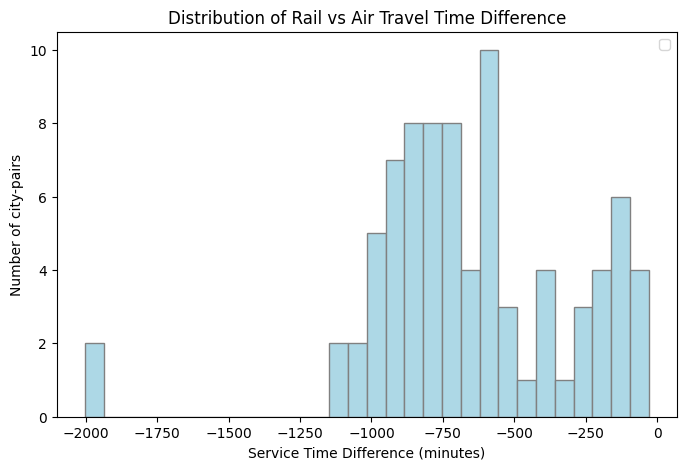

In [74]:
plt.figure(figsize=(8, 5))
plt.hist(city_routes["Service Time Difference"], bins=30, edgecolor="grey", color="lightblue")
plt.xlabel("Service Time Difference (minutes)")
plt.ylabel("Number of city-pairs")
plt.title("Distribution of Rail vs Air Travel Time Difference")
plt.legend()
plt.show()

### Normalized Distribution of Valued Air Travel Time and Rail Service Travel Time

If we look at the normalized distribution of air and rail times, it can be seen that all air travels take up to 400 minutes, while rail travel times are singificantly more distributed, with time reaching more than 2000 minutes.

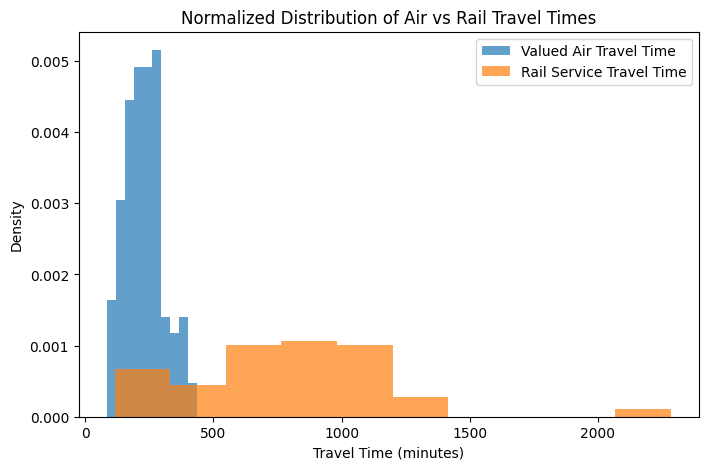

In [75]:
plt.figure(figsize=(8, 5))

plt.hist(
    city_routes["Valued Air Travel Time"],
    bins=10,
    alpha=0.7,
    density=True,
    label="Valued Air Travel Time"
)

plt.hist(
    city_routes["Rail Service Travel Time"],
    bins=10,
    alpha=0.7,
    density=True,
    label="Rail Service Travel Time"
)

plt.xlabel("Travel Time (minutes)")
plt.ylabel("Density")
plt.title("Normalized Distribution of Air vs Rail Travel Times")
plt.legend()
plt.show()

## Conclusion
Due to big geographical distances between big European cities, Air Travel is prefered in this case. It can be seen that for the twelve chosen big European cities, Service Time Difference is always negative, due to Rail Travel Time being always longer than Valued Air Travel Time.
There is only one route between two big cities where Rail does not take 1 hour more than Air Travel. That route is between Rome and Napoli, both located in Italy. <br>
It is important to mention that not all of the chosen cities are connected with rail. For example, Athens is not connected to any other city. 
The biggest difference between Rail and Air Travel Times is on the route between Lisbon and Milan, where Rail Travel takes around 30 hours longer.

# References
### BRUNO 2025
Bruno, F. (2025) *Assessing the Potential of Policies Targeting Air-to-Rail Modal Substitution: An Explorative Analysis.* Licentiate thesis. KTH Royal Institute of Technology. Available at: TRITA-ABE-DLT-2534. https://doi.org/10.1016/j.tranpol.2025.05.031
### World Population Review 2025
World Population Review (2025). *European city population dataset*. Online dataset. Available at: https://worldpopulationreview.com/cities/continent/europe (Accessed: 6 January 2026).
